# Cloud points view of a mesh


### Twitter Driven Developement 

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Now I have to try to generate a point cloud along the edges to simulate STORM images.


### Why?

Having a point based representation is not as futile as it sounds.

1. The file format is very simple (three columns), so easy to pass on
2. The point positions and densities can encode a lot of information
3. For our biology models, it is a straightforward route to reproducing 
   the images obtained from fluorescence microscopy, by simulating the
   (putative) distribution of a fluorescent marquer
4. Thinking in terms of density fields is exciting



### Loading a tyssue dataset 

In [1]:
import pandas as pd
import numpy as np

from tyssue.io import hdf5
from tyssue import config
from tyssue.core.monolayer import Monolayer

import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found - install it for neater graphs')

In [2]:
datasets = hdf5.load_datasets('../data/hf5/small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} s_{ij}, \quad s \in [0, 1]$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [3]:
from tyssue.io.csv import write_storm_csv
from tyssue.particles.point_cloud import EdgeSubdiv 

In [4]:
# Average number of particle by half-edge
density = 100
monolayer.edge_df['density'] = density# / monolayer.edge_df.length.median()
# Increase points density in the apical and basal layers
monolayer.edge_df.loc[monolayer.apical_edges, 'density'] *= 10.
monolayer.edge_df.loc[monolayer.basal_edges, 'density'] *= 10.

subdiv = EdgeSubdiv(monolayer.edge_df[['length', 'density']])
subdiv.specs['noise'] = 0.01
srce_pos = monolayer.upcast_srce(monolayer.vert_df[monolayer.coords])
r_ij = monolayer.edge_df[monolayer.dcoords]
subdiv.edge_point_cloud(srce_pos, r_ij)
subdiv.points.head()

,upcaster,offset,x,y,z
0,0,0.000000,0.499512,-0.026561,-0.973422
1,0,0.003367,0.514869,-0.026167,-0.983760
2,0,0.006734,0.519076,-0.018377,-0.999872
3,0,0.010101,0.512809,-0.030672,-0.959730
4,0,0.013468,0.508207,-0.027369,-0.972779


In [5]:
subdiv.edge_df.head()

,length,density,num_particles,x,dx,y,dy,z,dz
edge,,,,,,,,,
0,0.297880,1000.0,297,0.513495,0.090703,-0.034393,0.281272,-0.985173,0.037306
1,0.294302,1000.0,294,0.604199,0.138905,0.246878,0.043246,-0.947867,0.255829
2,0.314554,1000.0,314,0.611858,-0.098363,-0.209700,0.175307,-0.743230,-0.241943
3,0.342045,1000.0,342,0.777201,-0.165343,0.017019,-0.226719,-0.547642,-0.195588
4,0.310805,1000.0,310,0.743104,0.034098,0.290125,-0.273106,-0.692038,0.144396


In [6]:
subdiv.n_edges, subdiv.n_points

(1656, 162938)

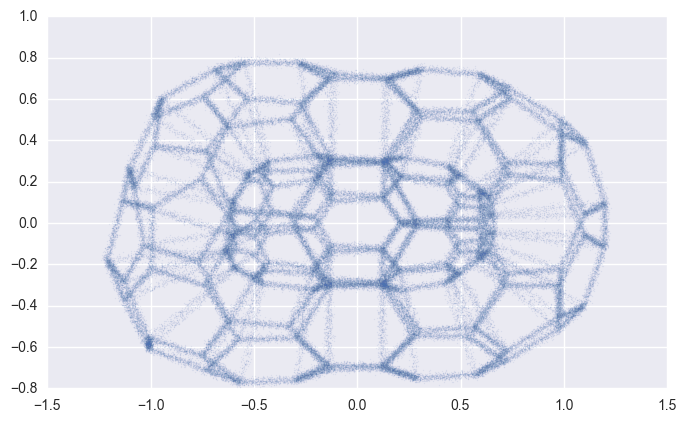

In [7]:
fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')


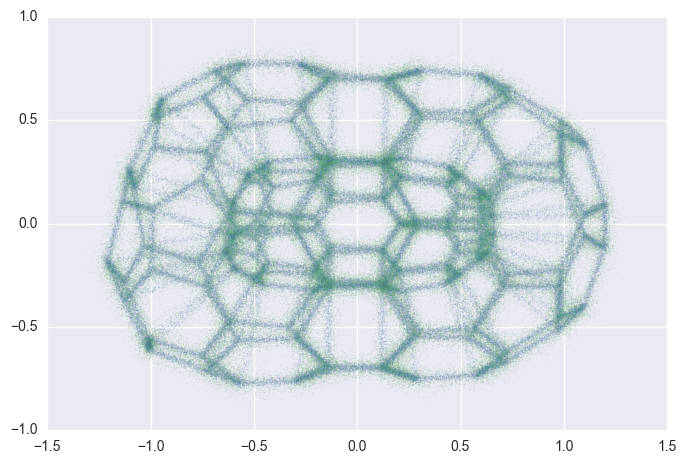

In [8]:
subdiv.specs['noise'] = 0.03
subdiv.edge_point_cloud(srce_pos, r_ij)
#fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')
fig

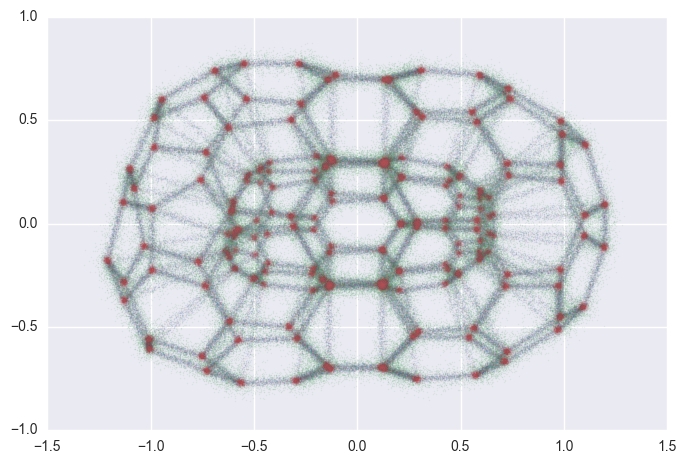

In [9]:
subdiv.specs['gamma'] = 4.
subdiv.specs['noise'] = 0.01

subdiv.update_density_lut()
subdiv.update_offset()
subdiv.edge_point_cloud(srce_pos, r_ij)
#fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.05)
ax.set_aspect('equal')
fig

In [10]:
## This is much slower, switch draw_scatter to execute
draw_scatter = False
if draw_scatter:
    fig, ax = plt.subplots()
    ax.scatter(subdiv.points.z.values,
               subdiv.points.x.values,
               marker='.', 
               s=subdiv.points.y.values*10,
               cmap='viridis',
               alpha=0.01)

    ax.set_aspect('equal')


### The 3D Storm format

Here is a screen shot of the file provided by Christophe:



![Crop of the 3D_STORM format in a tabulator](../data/png/3D_STORM_format.png)

In [13]:
### Configuration of the csv file format
csv_args = {'index':False, 'header':True, 'sep':'\t'}

subdiv.points['segment'] = monolayer.edge_df.loc[subdiv.points['upcaster'],
                                                 'segment'].values

filename = '../data/csv/ellipsoid'
write_storm_csv(filename, subdiv.points,
                coords=['x', 'y', 'z'],
                split_by=None, **csv_args)

In [14]:
ls -lht ../data/csv/

total 85M
-rw-r--r-- 1 guillaume guillaume  11M nov.   7 20:52 ellipsoid.csv
-rw-r--r-- 1 guillaume guillaume  35M nov.   7 14:22 ellipsoid_faces.csv
-rw-r--r-- 1 guillaume guillaume 238K nov.   6 19:43 ellipsoid_apical.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_sagittal.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_basal.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_3.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_2.csv
-rw-r--r-- 1 guillaume guillaume 8,6M oct.  28 10:43 ellipsoid_points_1.csv
-rw-r--r-- 1 guillaume guillaume  17M oct.  28 10:43 ellipsoid_points.csv


Now you can upload `ellipsoid_points.csv`, to [Felix's website](http://cake23.de/pointcloud-loader/) and voilà!
![Awesome](../data/png/tyssue_storm.png)


Here is the implementation of `write_storm_csv`.

```python
csv_args = {'index':False, 'header':True, 'sep':'\t'}
```

```python
def write_storm_csv(filename, points,
                    coords=['x', 'y', 'z'],
                    split_by=None, **csv_args):

    columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
               'uncertainty_xy', 'uncertainty_z']
    points = points.dropna()
    storm_points = pd.DataFrame(np.zeros((points.shape[0], 6)),
                                columns=columns)
    storm_points[['x [nm]', 'y [nm]', 'z [nm]']] = points[coords]
    storm_points['frame'] = 1
    storm_points[['uncertainty_xy',
                  'uncertainty_z']] = 2.1
    # tab separated values are faster and more portable than excel
    if split_by is None:
        if not filename.endswith('.csv'):
            filename = filename+'.csv'
        storm_points.to_csv(filename, **csv_args)
    elif split_by in points.columns():
        storm_points[split_by] = points[split_by]
        # separated files by the column split_by
        storm_points.groupby(split_by).apply(
            lambda df:df.to_csv('{}_{}.csv'.format(
                filename, df[split_by].iloc[0]),
                **csv_args))
```

## Generating particles from the faces

Let the average edge length $\ell$ be the unit length.


We basically are constructing a local base (non orthogonal, but direct)
with two edges:
* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_i$, $\mathbf{r}_{\alpha i}$ 

* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_j$, $\mathbf{r}_{\alpha j}$ 

The positions of the particles are expressed in this base.
In general, the postion of M is given by:
$$
\mathbf{r}_M = \mathbf{r}_\alpha
    + u_{\alpha i}^{M}  \mathbf{e}_{\alpha i}
    + u_{\alpha j}^{M} \mathbf{e}_{\alpha j}
$$

On the regular grid, the particle $M^{k \ell}$ has a position:

$$
\mathbf{r}_M^{k \ell} = \mathbf{r}_\alpha
    + k \mathbf{e}_{\alpha i}
    + \ell \mathbf{e}_{\alpha j}
$$

But regular grids are boring, so...

This gid can be deformed by introducing a scale free density modulation function $\sigma_{\alpha i}(k)$ such that:
$$
u_{\alpha i}^k = k \sigma_{\alpha i}(k), \quad \sigma_{\alpha i}(k)\in [0, 1]
$$
 

![Diagramm of face subdivision grid](../data/png/face_subdivision.png)

```python
# Not working for non square matrix:
n, m = 12, 18
ii, jj = np.tril_indices(n, k=0)
density = 5

x = (np.arange(n, 0, -1)/density)[ii]
y = (np.arange(0, m)/density)[jj]

fig, ax = plt.subplots()
for i, j in zip(ii, jj):
    pass
#x = x.max() - x
ax.plot(x, y, 'o')
ax.plot(0, 0, '+')
ax.set_aspect('equal')
ax.set_xlim(-0.1, n/density+0.1)
ax.set_ylim(-0.1, m/density+0.1)
```


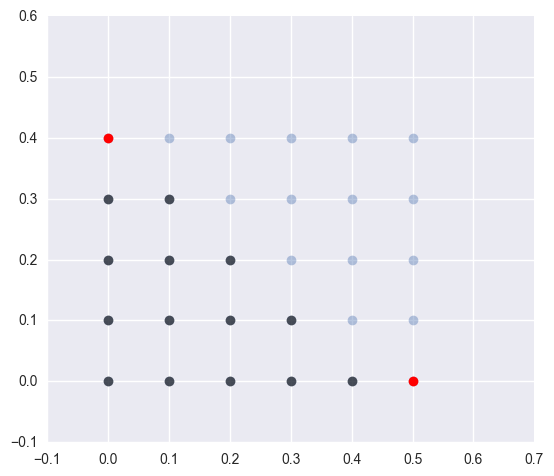

In [33]:
n, m = 6, 5
density = 10
ni = np.arange(0, n)
nj = np.arange(0, m)

nn, mm = np.meshgrid(ni, nj)
xx, yy = nn/density, mm/density 

l_ai, l_aj = xx.max(), yy.max()
in_out = (l_ai * l_aj - (l_aj*nn/density +
                         l_ai*mm/density)) > 0

fig, ax = plt.subplots()

ax.plot(xx.ravel(), yy.ravel(), 'o', alpha=0.4)

ax.plot(xx[in_out].ravel(), 
        yy[in_out].ravel(), 'ko', alpha=0.6)
ax.plot(0, 0, '+')
ax.plot(0, l_aj, 'ro')
ax.plot(l_ai, 0, 'ro')
ax.set_xlim(-0.1, n/density+0.1)
ax.set_ylim(-0.1, m/density+0.1)

ax.set_aspect('equal')



In [34]:
class FaceGrid:
    
    def __init__(self, edges_df, **kwargs):
        
        self.subdivs = {key: EdgeSubdiv(edge_df, **kwargs)
                        for key, edge_df in edges_df.items()}
        
        update_attrs = ['density_lut', 'particles',
                        'upcaster', 'offset']
        for attr in update_attrs:
            def _grid_attr():
                for key, subdiv in self.subdivs.items():
                    getattr(subdiv, 'update_'+attr)()
            setattr(self, 'update_'+attr, _grid_attr)
        
        self.n_points = np.product([subdiv.n_points for subdiv
                                    in self.subdivs.values()])
        self.dim = len(self.subdivs)
        self.up_cols = ['up_{}'.format(key) for key in self.subdivs]
        self.of_cols = ['of_{}'.format(key) for key in self.subdivs]
        grid_columns = self.up_cols + self.of_cols
        self.points = pd.DataFrame(
            np.zeros((self.n_points, 
                      len(grid_columns))),
            columns=grid_columns)
        
    def update_grid_upcaster(self):

        mgrid = np.meshgrid(
                *(subdiv.points['upcaster'].values
                for subdiv in self.subdivs.values()))
        for i, col in enumerate(self.up_cols):
            self.points[col] = mgrid[i].ravel()
        
    def update_gird_offset(self):
        off_grid = np.meshgrid(
            *(subdiv.points['offset'].values
            for subdiv in self.subdivs.values()))
        
        for i, col in enumerate(self.of_cols):
            self.points[col] = off_grid[i].ravel()

    
            

In [52]:
from tyssue.core import generation
from tyssue.core.sheet import Sheet
from tyssue.geometry.sheet_geometry import PlanarGeometry as geom
from tyssue.draw.plt_draw import quick_edge_draw

specs = config.geometry.planar_sheet()
datasets, _ = generation.three_faces_sheet()

eptm = Sheet('3_sheet', datasets, specs)
geom.update_all(eptm)


def upcast_pos(eptm, element):
    if element in ['srce', 'trgt']:
        dataset = 'vert'
    else:
        dataset = element
        
    eptm._upcast(eptm.edge_df[element], eptm.datasets[element][eptm.coords])

def get_edge_bases(eptm, center='face',
                   source='srce', target='trgt'):

    for element in [center, source, target]:
         edge_df = pd.DataFrame(srce_pos.values - face_pos.values,
                        columns=['dx', 'dy', 'dz'])

    edge_upcast_pos = {
        'face': eptm.upcast_face(eptm.face_df[eptm.coords]),
        'srce': eptm.upcast_srce(eptm.vert_df[eptm.coords]),
        'trgt': eptm.upcast_trgt(eptm.vert_df[eptm.coords])
        }
    
    edge_bases = {}
    for vertex in (source, target):
        
    face_to_srce_df['length'] = np.linalg.norm(face_to_srce_df[eptm.dcoords],
                                         axis=1)
    face_to_srce_df['density'] = 10
edge_bases[(center, vertex)]

face_to_trgt_df = pd.DataFrame(trgt_pos.values - face_pos.values,
                         columns=['dx', 'dy', 'dz'])
face_to_trgt_df['length'] = np.linalg.norm(face_to_trgt_df[eptm.dcoords],
                                     axis=1)

base_edges = {'alpha_i': face_to_srce_df.dropna(),
              'alpha_j': face_to_trgt_df.dropna()}

f_grid = FaceGrid(grid_edges)


In [53]:
f_grid.update_grid_upcaster()
f_grid.update_gird_offset()

In [54]:
f_grid.subdivs.keys()

dict_keys(['ftot', 'ftos'])

In [55]:
n_u, n_v = (subdiv.n_points for subdiv in f_grid.subdivs.values())
total_grid_size = n_u * n_v
print('Face to source upcaster: {} subdivisions'.format(n_u))
print('Face to target upcaster: {} subdivisions'.format(n_v))
print('Total grid size: {:e}'.format(np.float(total_grid_size)))

Face to source upcaster: 168 subdivisions
Face to target upcaster: 168 subdivisions
Total grid size: 2.822400e+04


In [57]:
f_grid.points.head()

,up_ftot,up_ftos,of_ftot,of_ftos
0,0,0,0.000000,0.0
1,0,0,0.111111,0.0
2,0,0,0.222222,0.0
3,0,0,0.333333,0.0
4,0,0,0.444444,0.0


In [63]:
edge_face_pos = eptm.upcast_face(monolayer.face_df[monolayer.coords])
grid_face_pos = edge_face_pos.loc[f_grid.points['up_ftos'].values,
                                  monolayer.coords]
up_dpos = {
    key: subdiv.edge_df.loc[
        f_grid.points['up_{}'.format(key)],
        eptm.dcoords]
    for key in f_grid.subdivs
    }

for c in eptm.coords:
    f_grid.points[c] = grid_face_pos[c].values
#    for key in f_grid.subdivs:
#        delta_u = (f_grid.points['of_{}'.format(key)]*
#                   up_dpos[key]['d'+c].values)
#        f_grid.points[c] += delta_u

In [64]:
f_grid.points.head(20)

,up_ftot,up_ftos,of_ftot,of_ftos,x,y,z
0,0,0,0.000000,0.0,0.649971,0.061986,-0.78319
1,0,0,0.111111,0.0,0.649971,0.061986,-0.78319
2,0,0,0.222222,0.0,0.649971,0.061986,-0.78319
3,0,0,0.333333,0.0,0.649971,0.061986,-0.78319
4,0,0,0.444444,0.0,0.649971,0.061986,-0.78319
5,0,0,0.555556,0.0,0.649971,0.061986,-0.78319
6,0,0,0.666667,0.0,0.649971,0.061986,-0.78319
7,0,0,0.777778,0.0,0.649971,0.061986,-0.78319
8,0,0,0.888889,0.0,0.649971,0.061986,-0.78319
9,1,0,0.000000,0.0,0.649971,0.061986,-0.78319


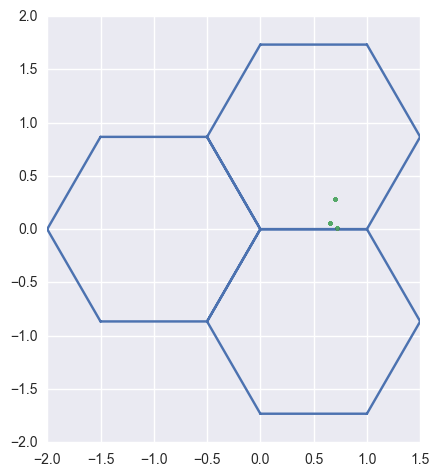

In [68]:
fig, ax = quick_edge_draw(eptm)
ax.plot(*grid_face_pos[['x', 'y']].T.values,
        '.', ms=5., alpha=0.1)
#ax.set_aspect('equal')

In [97]:
filename = '../data/csv/ellipsoid_faces'
write_storm_csv(filename, f_grid.points,
                monolayer, split_by=None,#'segment',
                **csv_args)

In [ ]:
fig, ax = plt.subplots()
ax.plot(points['z'].values[:int(1e4)],
        points['x'][:int(1e4)].values, '.', alpha=0.02)
ax.set_aspect('equal')

In [99]:
!ls -lht ../data/csv/

total 85M
-rw-r--r-- 1 guillaume guillaume  35M nov.   7 14:22 ellipsoid_faces.csv
-rw-r--r-- 1 guillaume guillaume  11M nov.   7 12:05 ellipsoid.csv
-rw-r--r-- 1 guillaume guillaume 238K nov.   6 19:43 ellipsoid_apical.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_sagittal.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_basal.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_3.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_2.csv
-rw-r--r-- 1 guillaume guillaume 8,6M oct.  28 10:43 ellipsoid_points_1.csv
-rw-r--r-- 1 guillaume guillaume  17M oct.  28 10:43 ellipsoid_points.csv


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(mesh.length.values/delta_s, 'o', alpha=0.2)
ax0.plot(upcast_nij, 'o', alpha=0.1)
ax0.set_ylabel('Number of points')

e_start, e_stop = 1000, 1010

p_start, p_stop = (curv_indexer[curv_indexer < e_start].size,
                   curv_indexer[curv_indexer < e_stop].size )

ax1.plot(ramps[p_start: p_stop], '-o', alpha=0.8)
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('normalized coordinate along the edges')

fig.set_size_inches((12, 6))
fig